In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2023-02-06 16:21:07.751982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_data = pd.read_csv('eda_simple_classification/network_data_mod_train.csv')
test_data = pd.read_csv('eda_simple_classification/network_data_mod_test.csv')

frames = [train_data, test_data]

dataframe  = pd.concat(frames)
raw_data = dataframe.values
#dataframe.head()
#raw_data



In [3]:
"""
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
train_data = dataframe.sample(frac = 0.8)
train_data = train_data[train_data["class"] != 0]
test_data = dataframe.drop(train_data.index)
"""



# The last element contains the labels
labels = raw_data[:, -1]

#print(test_data.columns )

data = raw_data[:, 0:-1]
#print(data)




train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=34
)



In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

2023-02-06 16:21:21.470480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
train_labels

array([1., 1., 0., ..., 0., 1., 1.])

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [7]:
normal_train_data.shape

TensorShape([61644, 47])

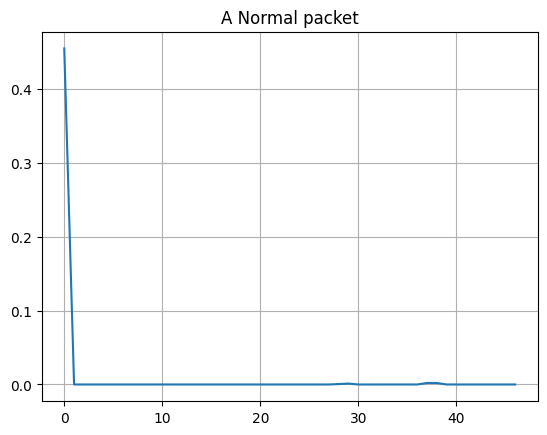

In [8]:
plt.grid()
plt.plot(np.arange(47), normal_train_data[0])
plt.title("A Normal packet")
plt.show()

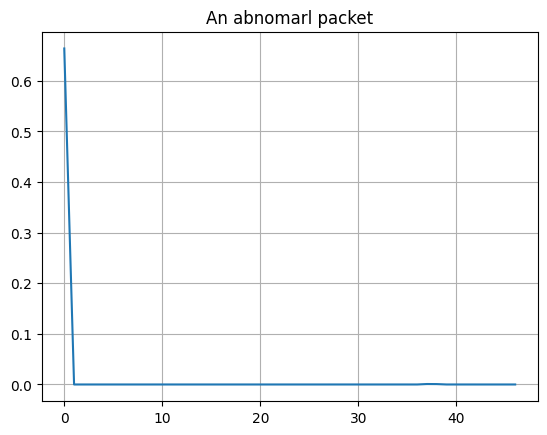

In [9]:
plt.grid()
plt.plot(np.arange(47), anomalous_train_data[0])
plt.title("An abnomarl packet")
plt.show()

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(47, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=5,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/500
1927/1927 [==============================] - 12s 4ms/step - loss: 0.0176 - val_loss: 3.4878e-04
Epoch 2/500
1927/1927 [==============================] - 10s 5ms/step - loss: 3.4641e-04 - val_loss: 3.5015e-04
Epoch 3/500
1927/1927 [==============================] - 10s 5ms/step - loss: 3.2971e-04 - val_loss: 3.6410e-04
Epoch 4/500
1927/1927 [==============================] - 9s 5ms/step - loss: 3.1253e-04 - val_loss: 2.9902e-04
Epoch 5/500
 182/1927 [=>............................] - ETA: 7s - loss: 3.1073e-04

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

In [ ]:
preds_01 = []
test_labels_01 = []
for item in preds:
  if item == True:
    preds_01.append(1)
  else:
    preds_01.append(0)

for item in test_labels:
  if item == True:
    test_labels_01.append(1)
  else:
    test_labels_01.append(0)

In [ ]:
print(preds_01)

In [ ]:
print(test_labels_01)